In [1]:
from jetstream_hugo.jet_finding import *
from jetstream_hugo.definitions import *
from jetstream_hugo.plots import *
from jetstream_hugo.clustering import *
from jetstream_hugo.data import *
import colormaps

%load_ext autoreload
%autoreload 2
%matplotlib inline

/storage/homefs/hb22g102/miniforge3/envs/env11_2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
exp_s = Experiment(
    "ERA5", "plev", "s", "6H", "all", "JJA", -80, 40, 15, 80, [175, 200, 225, 250, 300, 350], None, None, None, reduce_da=True
)

exp = MultiVarExperiment("ERA5", "plev", ["u", "v", "s"], "6H", "all", None, -80, 40, 15, 80, [175, 200, 225, 250, 300, 350])

all_jets_one_df, where_are_jets, all_jets_one_array, all_jets_over_time, flags = exp.track_jets()
props_as_ds_uncat = exp.props_as_ds(False)
props_as_ds = exp.props_as_ds(True)
da = exp.ds["s"]

jet_pos_da = jet_position_as_da(da, props_as_ds_uncat, all_jets_one_df, exp.path, processes=20, chunksize=100)
props_as_ds["nao"] = get_nao(props_as_ds)
overlap = (jet_pos_da > 0).any("lat").all("jet")
props_as_ds["double_jet_index"] = overlap.sel(lon=slice(-20, None, None)).mean("lon")

# test pairwise ssim

In [ ]:
its = np.random.randint(0, exp_s.samples_dims["time"].shape[0], size=20)
da_ = exp_s.da.isel(time=its)

In [ ]:
from simpsom.distances import pairwise_ssim
da_ = exp_s.da.isel(time=its)
da_ = to_zero_one(coarsen_da(da_, 1.5).values)[0]
data_range = da_.max() - da_.min()
results = pairwise_ssim(da_, win_size=3, strides=1, data_range=data_range.item())
results = results[np.triu_indices_from(results, k=1)]
results_2 = pairwise_distances(da_.reshape(da_.shape[0], -1))
results_2 = results_2[np.triu_indices_from(results_2, k=1)] / np.sqrt(np.prod(da_.shape[-2:])) * 2

fig, ax = plt.subplots(figsize=(15, 6))
# ax.plot(np.arange(len(results)), (results - results_2) / results_2, lw=4)
ax.plot(np.arange(len(results)), results, lw=4)
ax.plot(np.arange(len(results_2)), results_2, lw=4)

In [ ]:
np.mean(results / results_2 / 1.044067)

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(np.arange(len(results)), results, lw=4)
ax.plot(np.arange(len(results_2)), results_2 * 2, lw=4)

In [ ]:
clu = Clusterplot(1, 2, exp_s.region)
_ = clu.add_contourf(da_)

# compute CDSK indices

In [3]:
from CDSK import dynamical_local_indexes
X, da = exp_s.prepare_for_clustering()
X = exp_s.pca_transform(X, 100)
ld, theta, alpha = dynamical_local_indexes(X, n_jobs=10)
np.save(exp_s.path.joinpath("ld_100"), ld.squeeze())
np.save(exp_s.path.joinpath("theta_100"), theta.squeeze())

# Explicit SOM

In [ ]:
plt.ioff()
from IPython.display import display, clear_output
from simpsom.neighborhoods import Neighborhoods
%matplotlib inline

epochs = 100
start_sigma = 1
start_lr = 0.05
win_size = 7
nbatch = len(X_norm) // 64
lon, lat = da_s_coarse.lon.values, da_s_coarse.lat.values
nei = Neighborhoods(np, 6, 4, "hexagons", PBC=True)
neighborhood_caller = partial(nei.neighborhood_caller, neigh_func="gaussian")
size = nei.width * nei.height
weights = np.random.default_rng().random((size, *X_norm.shape[1:]), dtype=np.float32)
nodes = np.arange(size)
clu = None


def iteration_som(thisX: NDArray, weights: NDArray, nodes: NDArray, nbatch: int, win_size: int, data_range: float) -> NDArray:
    batches = np.array_split(thisX, nbatch)
    pre_numerator = np.zeros(weights.shape, dtype=np.float32)
    numerator = pre_numerator.copy()
    for batch in tqdm(batches):
        distances = pairwise_ssim(batch, weights, win_size, data_range)
        indices = np.argmin(distances, axis=1)
        
        series = indices[:, None] == nodes[None, :]
        pop = np.sum(series, axis=0, dtype=np.float32)
        for i, s in enumerate(series.T):
            pre_numerator[i, :, :] = np.sum(batch[s], axis=0)
        for i in range(pre_numerator.shape[0]):
            numerator[i, :, :] = np.sum(h[i, :, None, None] * pre_numerator, axis=0)
        
        # numerator = np.einsum('ij, jkl -> ikl', h, numerator)
        denominator = (h @ pop)[:, None, None]
        
        new_weights = np.where(denominator != 0, numerator / denominator, weights)
        weights = (1 - learning_rate) * weights + learning_rate * new_weights
        weights = weights.astype(np.float32)
    return weights


def prepare_plot(weights, lon, lat, Xmin, Xmax):
    weights = descale(weights, Xmin, Xmax)
    weights_to_plot = xr.DataArray(weights, coords={"cluster": nodes, "lat": lat, "lon": lon})
    return weights_to_plot.where(weights_to_plot > 0, 0) / norm_da


def prepare_plot_pca(weights, pca, lon, lat):
    weights_to_plot = pca.inverse_transform(weights).reshape(weights.shape[0], *da_s.shape[1:])
    weights_to_plot = xr.DataArray(weights_to_plot, coords={"cluster": nodes, "lat": lat, "lon": lon})
    return weights_to_plot.where(weights_to_plot > 0, 0) / norm_da


for epoch in range(epochs):
    sigma = start_sigma * np.exp(-epoch / epochs * 3)
    learning_rate = start_lr * np.exp(-epoch / epochs)
    thisX = X_norm.copy()
    np.random.shuffle(thisX)
    h = neighborhood_caller(nodes, sigma=sigma).astype(np.float32)
    weights = iteration_som(thisX, weights, nodes, nbatch, win_size, data_range)   
    weights_to_plot = prepare_plot(weights, lon, lat, Xmin, Xmax) 
    if clu:
        plt.close(clu.fig)
        del clu
    clear_output(wait = True)
    print(f'ite: {epoch + 1}/{epochs}, lr: {learning_rate:.2e}, sigma: {sigma:.2e}', end='\r')
    clu = Clusterplot(nei.height, nei.width, exp_s.region, honeycomb=True)
    clu.add_contourf(weights_to_plot, q=0.97, transparify=2, cmap=colormaps.matter)  
    display(clu.fig)
if clu:
    plt.close(clu.fig)
    del clu

# Sweep sizes

In [4]:
from simpsom.neighborhoods import Neighborhoods
def pairwise_distances_wrapper(X, Y=None, **kwargs):
    X = X.reshape(X.shape[0], -1)
    if Y is not None:
        Y = Y.reshape(Y.shape[0], -1)
    return pairwise_distances(X, Y, **kwargs)

metric = "euclidean"
its = np.random.randint(0, exp_s.da.time.shape[0], size=10000)
X = to_zero_one(coarsen_da(exp_s.da.isel(time=its), 1.5).values)[0]
meanX = X.mean(axis=0)[None, ...]
stdX = X.std(axis=0)[None, ...]
X_norm = (X - meanX) / stdX

In [5]:
all_x = np.arange(4, 11, 2)
all_dx = [0, -2]
bics1 = np.zeros((len(all_x), len(all_dx)))
bics2 = bics1.copy()
maxprojs = bics1.copy()
for i, x in tqdm(enumerate(all_x), total=len(all_x)):
    for j, dx in enumerate(all_dx):
        net, centers, labels = exp_s.som_cluster(
            x,
            x + dx,
            metric=metric,
            return_type=RAW_REALSPACE,
            force=False,
            train_kwargs=dict(train_algo="batch", epochs=50, start_learning_rate=0.05),
        )
        weights = np.load(exp_s.path.joinpath(f"som_{x}_{x+dx}_pbc_euclidean.npy"))
        m, sx, sy = weights.shape
        meanW, stdW = weights.mean(axis=0), weights.std(axis=0)
        weights_norm = (weights - meanW) / stdW
        distances = pairwise_distances_wrapper(X_norm, weights_norm, n_jobs=12, metric="sqeuclidean")
        neighborhood = Neighborhoods(x, x + dx, "hexagons", PBC=True)
        h = neighborhood.neighborhood_caller(np.arange(m), 0.05, "gaussian")
        distances_ = h @ distances.T
        labels = np.argmin(distances_, axis=0)
        masks = labels_to_mask(labels)
        n = np.sum(masks, axis=0)
        N = X.shape[0]
        d = sx * sy
        loss = np.sum(np.amin(distances_, axis=0))
        bics1[i, j] = (1.0 / (N - m) / d) * loss + m * d * np.log(N)
        
        cl_var = (1.0 / (N - m) / d) * loss
        const_term = 2 * m * np.log(N) * d
        bics2[i, j] = np.sum(n * np.log(n) - n * np.log(N) - n * d / 2 * np.log(2 * np.pi * cl_var) - (n - 1) * d / 2) - const_term
        
        maxprojs[i, j] = (1.0 / d) * np.amin(np.amax(np.einsum('ikl, jkl -> ij', X_norm, weights_norm), axis=1))

100%|██████████| 4/4 [57:06<00:00, 856.67s/it]


In [6]:
np.save("/storage/homefs/hb22g102/persistent-extremes-era5/results/bics1.npy", bics1)
np.save("/storage/homefs/hb22g102/persistent-extremes-era5/results/bics2.npy", bics2)
np.save("/storage/homefs/hb22g102/persistent-extremes-era5/results/maxprojs.npy", maxprojs)

In [23]:
maxprojs = np.load("/storage/homefs/hb22g102/persistent-extremes-era5/results/som_maxprojs.npy")
losses = np.load("/storage/homefs/hb22g102/persistent-extremes-era5/results/som_losses.npy")

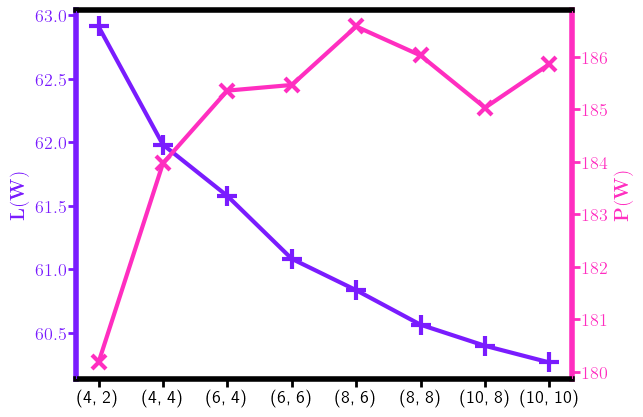

In [30]:
c1 = COLORS[2]
c2 = COLORS[1]

fig, ax = plt.subplots()
all_x = np.arange(4, 11, 2)
all_dx = [0, -2]
ax.plot(losses[:, [1, 0]].flatten(), color=c2, lw=3, marker="+", ms=15, mew=3)
ax.set_xticks(np.arange(8), [f'({x}, {x+dx})' for x, dx in product(all_x, all_dx[::-1])], fontsize=13)
ax.set_ylabel("$\mathbf{L(W)}$", fontsize=14)
ax.spines['left'].set_color(c2)
ax.spines['right'].set_color(c1)
ax.tick_params(color=c2, labelcolor=c2, axis="y")
ax.yaxis.label.set_color(c2)

axx = ax.twinx()
axx.plot(maxprojs[:, [1, 0]].flatten(), color=c1, lw=3, marker="x", ms=10, mew=3)
axx.spines['right'].set_color(c1)
axx.spines['left'].set_color(c2)
axx.set_ylabel("$\mathbf{P(W)}$", fontsize=14)
axx.yaxis.label.set_color(c1)
axx.tick_params(color=c1, labelcolor=c1, axis="y")

for dire in ['top','bottom','left','right']:
    ax.spines[dire].set_linewidth(4)

ax.tick_params(width=2, length=6, pad=1, labelsize=13)
axx.tick_params(width=2, length=6, pad=1, labelsize=13)
    
plt.savefig(f"{FIGURES}/som_training.png")

In [ ]:
fig, ax = plt.subplots()
all_x = np.arange(4, 11, 2)
all_dx = [0, -2]
ax.plot(losses[:, [1, 0]].flatten(), color="red", lw=2)
ax.set_xticks(np.arange(8), [f'({x}, {x+dx})' for x, dx in product(all_x, all_dx[::-1])])
ax.set_ylabel("SOM Loss")
ax.spines['left'].set_color('red')
ax.spines['right'].set_color('blue')
ax.tick_params(color='red', labelcolor='red', axis="y")
ax.yaxis.label.set_color('red')


axx = ax.twinx()
axx.plot(maxprojs[:, [1, 0]].flatten(), color="blue", lw=2)
axx.spines['right'].set_color('blue')
axx.spines['left'].set_color('red')
axx.set_ylabel("Min Proj")
axx.yaxis.label.set_color('blue')
axx.tick_params(color='blue', labelcolor='blue', axis="y")

plt.savefig(f"{FIGURES}/som_training.png")

In [ ]:
list(ax.spines.keys())

In [ ]:
fig, ax = plt.subplots()
ax.plot(maxprojs[:, [1, 0]].flatten())
ax.set_xticks(np.arange(8), [f'({x}, {x+dx})' for x, dx in product(all_x, all_dx[::-1])])

# SOMs basic

In [3]:
metric = "euclidean"
nx = 6
ny = 4
ds_center_path = exp_s.path.joinpath(f"som_{nx}_{ny}_pbc_{metric}_center.nc")
if not ds_center_path.is_file():
    ds = exp.ds
    ds = ds.sel(time=ds.time.dt.season=="JJA")
net, centers, labels = exp_s.som_cluster(
    nx,
    ny,
    metric=metric,
    return_type=RAW_REALSPACE,
    force=False,
    train_kwargs=dict(train_algo="batch", epochs=50, start_learning_rate=0.05),
)
populations = net.compute_populations()
coords = net.neighborhoods.coordinates
if not ds_center_path.is_file():
    ds_center = labels_to_centers(labels, ds)
    ds_center.to_netcdf(ds_center_path)
else:
    ds_center = xr.open_dataset(ds_center_path)
labels = xr.DataArray(labels, coords={"time": exp_s.samples_dims["time"]})
mask = labels_to_mask(labels)
mask_da = xr.DataArray(mask, coords={"time": exp_s.da.time, "cluster": np.arange(net.n_nodes)})

In [ ]:
centers_all_jets = find_all_jets(ds_center.load(), processes=1, jet_threshold=0.9e8, wind_threshold=21, alignment_threshold=0.3, mean_alignment_threshold=0.5)
centers_all_jets_df = all_jets_to_one_df(centers_all_jets, time=np.arange(net.n_nodes), time_name="cluster")
centers_props_ds_uncat = compute_all_jet_props(centers_all_jets_df, centers)
centers_props_ds = categorize_ds_jets(centers_props_ds_uncat)
props_as_ds_summer = props_as_ds.sel(time=props_as_ds.time.dt.season=="JJA")

In [6]:
def to_prettier_order(n: int, width: int = 6, height: int = 4):
    col, row = divmod(n, height)
    row = height - 1 - row
    return 1 + width * row + col

## Error

In [110]:
distances = np.zeros(net.n_nodes)
for i in trange(net.n_nodes):
    w = net.weights[i].flatten()[None, :]
    mask = labels.data == i
    x = net.data[mask] .reshape(np.sum(mask), -1) 
    distances[i] = np.mean(pairwise_distances(x, w))

100%|██████████| 24/24 [00:00<00:00, 63.32it/s]


Text(0.5, 1.0, 'Error')

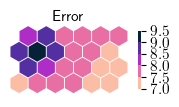

In [124]:
fig, ax = plt.subplots(figsize=(0.33 * TEXTWIDTH_IN, 1.2), tight_layout=False, subplot_kw={"aspect": "equal"})
cmap = colormaps.bubblegum_r
norm = BoundaryNorm(np.arange(7, 10, .5), cmap.N)
fig, ax = net.plot_on_map(distances, fig=fig, ax=ax, cmap=cmap, norm=norm, cmap_kwargs=dict(shrink=1.))
ax.set_title("Error")

## Intransivity ?

In [4]:
time_mask = labels.time.dt.dayofyear.values < (labels.time.dt.dayofyear[0].item() + 7)
winners = {lab: [] for lab in np.concatenate([[-1], np.arange(24)])}
for year in YEARS:
    time_mask_ = time_mask & (labels.time.dt.year.values == year)
    un, co = np.unique(labels[time_mask_].values, return_counts=True)
    co = co / time_mask_.sum()
    winner = np.where(co > 0.5)[0]
    if len(winner) == 0:
        winner = -1
        co = co.tolist()
    else:
        co = co[winner[0]]
        winner = un[winner[0]]
    winners[winner].append(year)

In [5]:
ja_mask = np.isin(labels.time.dt.month, [7, 8])
ja_pop = np.asarray([np.sum(labels[ja_mask] == i) for i in range(24)]) / len(YEARS)
pop_differences = {}
for winner, yearlist in winners.items():
    if len(yearlist) < 2:
        continue
    this_mask = ja_mask & np.isin(labels.time.dt.year, yearlist)
    this_pop = np.asarray([np.sum(labels[this_mask] == i) for i in range(24)]) / len(yearlist)
    pop_differences[winner] = (this_pop - ja_pop) / ja_pop

/scratch/local/1881842/ipykernel_806453/1423948502.py:9: RuntimeWarning: invalid value encountered in divide
  pop_differences[winner] = (this_pop - ja_pop) / ja_pop
/scratch/local/1881842/ipykernel_806453/1423948502.py:9: RuntimeWarning: invalid value encountered in divide
  pop_differences[winner] = (this_pop - ja_pop) / ja_pop
/scratch/local/1881842/ipykernel_806453/1423948502.py:9: RuntimeWarning: invalid value encountered in divide
  pop_differences[winner] = (this_pop - ja_pop) / ja_pop
/scratch/local/1881842/ipykernel_806453/1423948502.py:9: RuntimeWarning: invalid value encountered in divide
  pop_differences[winner] = (this_pop - ja_pop) / ja_pop


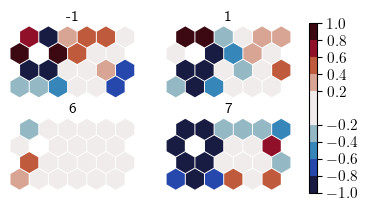

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(0.66 * TEXTWIDTH_IN, 2.2), tight_layout=False, subplot_kw={"aspect": "equal"})
cmap = colormaps.balance
norm = BoundaryNorm(np.delete(np.arange(-1, 1.01, .2), 5), cmap.N)
im = ScalarMappable(norm, cmap)
fig.colorbar(im, ax=axes, spacing="proportional")
for (winner, pop_diffs), ax in zip(pop_differences.items(), axes.ravel()):
    fig, ax = net.plot_on_map(
        pop_diffs,
        smooth_sigma=0,
        show=False,
        cmap=cmap,
        norm=norm,
        fig=fig,
        ax=ax,
        draw_cbar=False,
    )
    ax.set_title(winner, pad=2)
fig.set_tight_layout(False)

In [7]:
time_mask = labels.time.dt.dayofyear.values < (labels.time.dt.dayofyear[0].item() + 7)
thisnao = props_as_ds["nao"][props_as_ds.time.dt.season == "JJA"]
winners = {-1: [], 0: [], 1: []}
for year in YEARS:
    time_mask_ = time_mask & (labels.time.dt.year.values == year)
    co = np.mean(thisnao[time_mask_].values)
    co = 0 if np.abs(co) < .5 else co
    winners[np.sign(co)].append(year)

In [8]:
ja_mask = np.isin(labels.time.dt.month, [7, 8])
ja_pop = np.asarray([np.sum(labels[ja_mask] == i) for i in range(24)]) / len(YEARS)
pop_differences = {}
for winner, yearlist in winners.items():
    if len(yearlist) < 2:
        continue
    this_mask = ja_mask & np.isin(labels.time.dt.year, yearlist)
    this_pop = np.asarray([np.sum(labels[this_mask] == i) for i in range(24)]) / len(yearlist)
    pop_differences[winner] = (this_pop - ja_pop) / ja_pop

/scratch/local/1881842/ipykernel_806453/1423948502.py:9: RuntimeWarning: invalid value encountered in divide
  pop_differences[winner] = (this_pop - ja_pop) / ja_pop
/scratch/local/1881842/ipykernel_806453/1423948502.py:9: RuntimeWarning: invalid value encountered in divide
  pop_differences[winner] = (this_pop - ja_pop) / ja_pop
/scratch/local/1881842/ipykernel_806453/1423948502.py:9: RuntimeWarning: invalid value encountered in divide
  pop_differences[winner] = (this_pop - ja_pop) / ja_pop


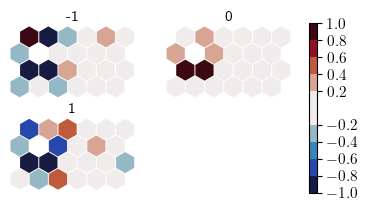

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(0.66 * TEXTWIDTH_IN, 2.2), tight_layout=False, subplot_kw={"aspect": "equal"})
cmap = colormaps.balance
norm = BoundaryNorm(np.delete(np.arange(-1, 1.1, .2), 5), cmap.N)
im = ScalarMappable(norm, cmap)
fig.colorbar(im, ax=axes, spacing="proportional")
for (winner, pop_diffs), ax in zip(pop_differences.items(), axes.ravel()):
    fig, ax = net.plot_on_map(
        pop_diffs,
        smooth_sigma=0,
        show=False,
        cmap=cmap,
        norm=norm,
        fig=fig,
        ax=ax,
        draw_cbar=False,
    )
    ax.set_title(winner, pad=2)
axes[-1, -1].set_visible(False)
fig.set_tight_layout(False)

In [78]:
yearly_trans_mat = np.zeros((len(YEARS), net.n_nodes, net.n_nodes))
start_point = 0
step = 1
labels_ = labels.sel(time=np.isin(labels.time.dt.month, [7, 8]))
yearbreak = np.sum(labels_.time.dt.year.values == 1999)
for i, end_point in enumerate(range(yearbreak, len(labels_) + 1, yearbreak)): # cleaner version with slices instead of fixed length summer if I ever need to to it for winter ? Flemme
    real_end_point = min(end_point, len(labels_) - 1)
    theseind = np.vstack(
        [labels_[start_point:real_end_point-step], np.roll(labels_[start_point:real_end_point], -step
    )[:-step]]).T
    theseind, counts = np.unique(theseind, return_counts=True, axis=0)
    this_transmat = yearly_trans_mat[i].copy()
    this_transmat[theseind[:, 0], theseind[:, 1]] = counts
    yearly_trans_mat[i] = this_transmat
    start_point = real_end_point
yearly_trans_mat /= np.sum(yearly_trans_mat, axis=2)[..., None]
yearly_trans_mat = np.nan_to_num(yearly_trans_mat, nan=0)

/scratch/local/1881842/ipykernel_806453/658302621.py:16: RuntimeWarning: invalid value encountered in divide
  yearly_trans_mat /= np.sum(yearly_trans_mat, axis=2)[..., None]


In [88]:
X = yearly_trans_mat.reshape(len(YEARS), -1)
from sklearn.cluster import Birch, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score
for n_clusters in range(2, 10):
    labels_transmats = Birch(n_clusters=n_clusters).fit_predict(X)
    print(n_clusters, silhouette_score(X, labels_transmats), calinski_harabasz_score(X, labels_transmats))

2 0.07501811956600882 5.3883386560612765
3 0.07323297722405772 4.806667730669339
4 0.04739283357221224 4.3624958064083525
5 0.05685043587675588 4.080883322559213
6 0.051143386501332246 3.933292342394519
7 0.04828037933152392 3.86190195101428
8 0.053716165065639615 3.8104296496403203
9 0.05973776398124684 3.749469920633476


In [106]:
n_clusters = 2
year_labels = Birch(n_clusters=n_clusters).fit_predict(X)
june_pops = np.zeros((n_clusters, net.n_nodes))
time_mask = labels.time.dt.dayofyear.values < (labels.time.dt.dayofyear[0].item() + 7)
un, june_pop_ = np.unique(labels[time_mask].values, return_counts=True)
june_pop = np.zeros(net.n_nodes)
june_pop[un] = june_pop_ / len(YEARS)
for i, year in enumerate(YEARS):
    time_mask_ = time_mask & (labels.time.dt.year == year)
    un, co = np.unique(labels[time_mask_].values, return_counts=True)
    thispop = np.zeros(net.n_nodes)
    thispop[un] = co
    june_pops[year_labels[i], :] += thispop
_, counts = np.unique(year_labels, return_counts=True)
june_pops /= counts[:, None]
june_pops -= june_pop[None, :]

In [107]:
june_pops

array([[ 0.     ,  0.37877,  0.31466,  0.46282, -0.01562, -0.54256,
         0.1681 , -1.14494,  0.     ,  0.     ,  0.41325,  0.     ,
         0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
         0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ],
       [ 0.     , -0.31384, -0.26071, -0.38348,  0.01295,  0.44955,
        -0.13929,  0.94866,  0.     ,  0.     , -0.34241,  0.     ,
         0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
         0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ]])

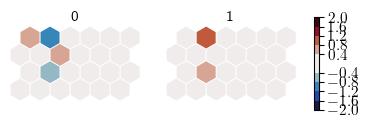

In [110]:
fig, axes = plt.subplots(1, 2, figsize=(0.66 * TEXTWIDTH_IN, 1.2), tight_layout=False, subplot_kw={"aspect": "equal"})
cmap = colormaps.balance
norm = BoundaryNorm(np.delete(np.arange(-2, 2.1, .4), 5), cmap.N)
im = ScalarMappable(norm, cmap)
fig.colorbar(im, ax=axes, spacing="proportional")
for i, (june_pop, ax) in enumerate(zip(june_pops, axes)):
    fig, ax = net.plot_on_map(
        june_pop,
        smooth_sigma=0,
        show=False,
        cmap=cmap,
        norm=norm,
        fig=fig,
        ax=ax,
        draw_cbar=False,
    )
    ax.set_title(i, pad=2)
fig.set_tight_layout(False)

## Typical summer pathway

In [5]:
timestepwise = []
group = [] 
for i, (_, group_) in enumerate(labels.groupby(labels.time.dt.dayofyear).groups.items()):
    group.append(group_)
    if i % 7 != 6:
        continue
    group = np.concatenate(group)
    coords = net.neighborhoods.coordinates[labels[group]]
    unique, count = np.unique(labels[group], return_counts=True)
    
    coordsmax = coords.max(axis=0, keepdims=True)
    thetas = coords / coordsmax * 2 * np.pi
    xi, zeta = np.cos(thetas), np.sin(thetas)
    mxi, mzeta = np.mean(xi, axis=0), np.mean(zeta, axis=0)
    com = np.arctan2(-mzeta, -mxi) + np.pi
    com = com / 2 / np.pi * coordsmax
    
    maxdx = net.width
    maxdy = net.height
    dx = np.abs(coords[:, 0] - com[0, 0])
    dy = np.abs(coords[:, 1] - com[0, 1])
    mask_periodic = dx > maxdx
    dx[mask_periodic] = maxdx - dx[mask_periodic]
    mask_periodic = dy > maxdy
    dy[mask_periodic] = maxdy - dy[mask_periodic]
    stdx = np.sqrt(np.sum(dx ** 2) / (len(dx) - 1))
    stdy = np.sqrt(np.sum(dy ** 2) / (len(dy) - 1))
    variab = np.asarray([stdx, stdy])
    timestepwise.append((com.squeeze(), variab.squeeze(), unique, count))
    group = []
    
com = np.asarray([step_[0] for step_ in timestepwise])
com_std = np.asarray([step_[1] for step_ in timestepwise])

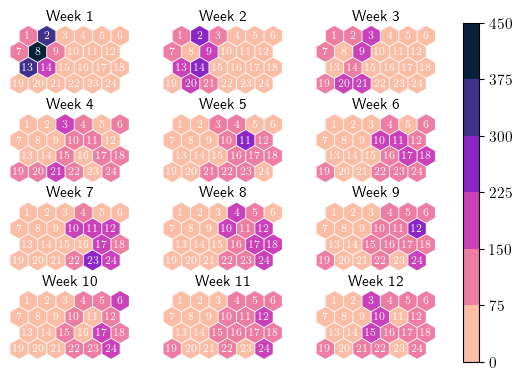

In [11]:
fig, axes = plt.subplots(4, 3, figsize=(TEXTWIDTH_IN, 4.4), tight_layout=False, subplot_kw={"aspect": "equal"})
cmap = colormaps.bubblegum_r
norm = BoundaryNorm(np.arange(0, 451, 75), cmap.N)
im = ScalarMappable(norm, cmap)
coords = net.neighborhoods.coordinates
fig.colorbar(im, ax=axes)
for i, ax in enumerate(axes.ravel()):
    step = i + 1
    unique, counts = timestepwise[step][2], timestepwise[step][3]
    to_plot = np.zeros(net.n_nodes)
    to_plot[unique] = counts
    fig, ax = net.plot_on_map(
        to_plot,
        smooth_sigma=0,
        show=False,
        cmap=cmap,
        norm=norm,
        fig=fig,
        ax=ax,
        draw_cbar=False,
    )
    # ax.errorbar(*com[step], *com_std[step][[1, 0]])
    ax.set_title(f"Week {step}", pad=2)
    
    for i, c in enumerate(coords):
        x, y = c
        ax.text(x, y, f'${to_prettier_order(i)}$', va='center', ha='center', color="white", fontsize=8)
fig.set_tight_layout(False)
plt.savefig(f"{FIGURES}/som_props/weekly_pathway.png")

In [241]:
coords = net.neighborhoods.coordinates
com_t = np.asarray(list(map(tuple, com)), dtype="f,f")
coords_t = np.asarray(list(map(tuple, coords)), dtype="f,f")

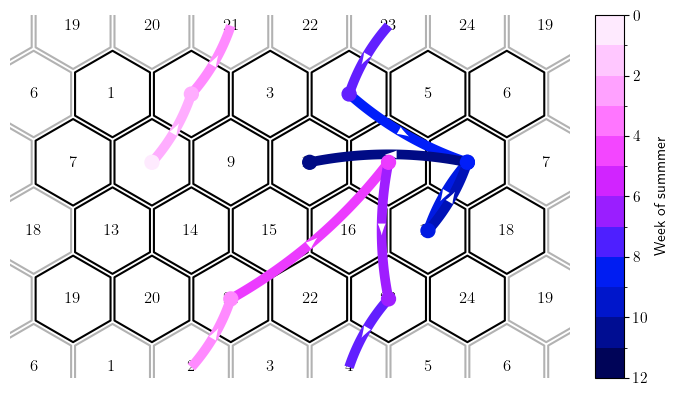

In [15]:
from simpsom.plots import create_outer_grid, traj_to_segments, segments_to_arcs, plot_map
from matplotlib.collections import PatchCollection, LineCollection

outer_grid, inner_grid, coords, outermask = create_outer_grid(net.width, net.height)
edgecolors = np.full(len(coords), "black", dtype=object)
edgecolors[outermask] = "black"
alphas = np.ones(len(coords))
alphas[outermask] = 0.3

traj = []
for step_ in timestepwise:
    unique, counts = step_[2:]
    traj.append(unique[np.argmax(counts)])
traj = np.asarray(traj)   
# traj = np.argmin(pairwise_distances(com, net.neighborhoods.coordinates), axis=1) 
traj_split = np.split(traj, np.where((np.diff(traj) != 0))[0] + 1)
sizes = np.asarray([len(stay) for stay in traj_split])
uniques = np.asarray([stay[0] for stay in traj_split])
color_array = np.asarray([0, *np.cumsum(sizes)], dtype=int)
cmap = colormaps.cet_l_bmw1_r
colors = cmap(np.linspace(0, 1, len(traj) + 1))[color_array]
sort_like = np.argsort(sizes)[::-1]
    
segments, reps = traj_to_segments(traj_split, coords, outer_grid, outermask)
arcs, arrows = segments_to_arcs(segments)

gs = plt.GridSpec(
    1,
    3,
    width_ratios=[1, 0.02, 0.05],
    wspace=0.01,
    left=0.01,
    right=0.9,
    bottom=0.01,
    top=0.99,
)
fig = plt.figure(figsize=(TEXTWIDTH_IN, 3.7))
ax = fig.add_subplot(gs[0], aspect="equal")
ax_cbar = fig.add_subplot(gs[2])
inner_coords = coords[~outermask]
xlims = [
    np.amin(inner_coords[:, 0]) - 0.8,
    np.amax(inner_coords[:, 0]) + 0.8,
]
ylims = [
    np.amin(inner_coords[:, 1]) - 1,
    np.amax(inner_coords[:, 1]) + 1,
]

fig, ax = plot_map(
    coords,
    np.zeros(len(coords)) + np.nan,
    "hexagons",
    draw_cbar=False,
    show=False,
    edgecolors=edgecolors,
    alphas=alphas,
    linewidths=1.5,
    fig=fig,
    ax=ax,
)
for i, c in enumerate(coords):
    x, y = c
    if x > xlims[0] and x < xlims[-1] and y > ylims[0] and y < ylims[-1]: 
        ax.text(x, y, f'${to_prettier_order(outer_grid.flatten()[i])}$', va='center', ha='center', color="black", fontsize=15)
lc = LineCollection(arcs, colors=np.repeat(colors[1:-1], reps, axis=0), zorder=3)
lc.set_linewidth(7)
lc = ax.add_collection(lc)
arrows = PatchCollection(arrows, zorder=9, edgecolor=None, facecolor="white")
ax.add_collection(arrows)
im = ScalarMappable(BoundaryNorm(np.arange(0, len(traj)), cmap.N), cmap)
cbar = fig.colorbar(
    im,
    cax=ax_cbar,
    label="Week of summmer"
)
uniques = uniques[sort_like]
sizes = sizes[sort_like]
colors = colors[:-1][sort_like]
ax.scatter(*coords[~outermask][uniques].T, s=100, c=colors, zorder=10)
colors = cmap(np.linspace(0, 1, len(com)))
# for color, com_, com_std_ in zip(colors, com, com_std):
#     com_ = com_ + np.asarray([ 4., 3.4641 ])
#     ax.errorbar(*com_, *com_std_[[1, 0]], zorder=10, color=color)
ax_cbar.invert_yaxis()
ax.set_xlim(xlims)
ax.set_ylim(ylims)
plt.savefig(f"{FIGURES}/som_props/track_com.png")

## DST

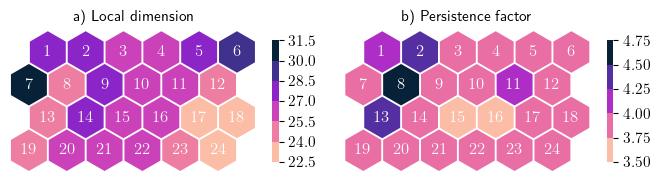

In [45]:
ld = np.load(exp_s.path.joinpath("ld_100.npy"))
theta = np.load(exp_s.path.joinpath("theta_100.npy"))

to_plot_ld = timeseries_on_map(ld, net.bmus)[0]
to_plot_theta = timeseries_on_map(1 / theta, net.bmus)[0]

cmap = colormaps.bubblegum_r
fig, axes = plt.subplots(1, 2, figsize=(1. * TEXTWIDTH_IN, 2), tight_layout=False, subplot_kw=dict(aspect="equal"))
fig, axes[0] = net.plot_on_map(
    to_plot_ld,
    smooth_sigma=0,
    show=False,
    cmap=cmap,
    fig=fig,
    ax=axes[0],
    discretify=True,
)
axes[0].set_title("a) Local dimension")
fig, axes[1] = net.plot_on_map(
    to_plot_theta,
    smooth_sigma=0,
    fig=fig,
    cmap=cmap,
    ax=axes[1],
    discretify=True,
)
axes[1].set_title("b) Persistence factor")
coords = net.neighborhoods.coordinates
for i, c in enumerate(coords):
    x, y = c
    for ax in axes:
        ax.text(x, y, f'${to_prettier_order(i)}$', va='center', ha='center', color="white", fontsize=10)
fig.savefig(f'{FIGURES}/som_props/DST.png')

## pops, stats

In [46]:
da = exp_s.da
df = pd.read_csv(f"{DATADIR}/ERA5/daily_nao.csv", delimiter=",")
index = pd.to_datetime(df.iloc[:, :3])
series = xr.DataArray(df.iloc[:, 3].values, coords={"time": index})
nao_summer = series.interp_like(da)
nao_on_map = timeseries_on_map(nao_summer, net.bmus)[0]

yearly = mask_da.resample(time="1YE").sum().values
trends = np.zeros(net.n_nodes)
pvalues = trends.copy()
for k, yearly_ in enumerate(yearly.T):
    trends[k], _, _, pvalues[k], _ = linregress(
        np.arange(yearly.shape[0])[yearly_ != 0], yearly_[yearly_ != 0]
    )


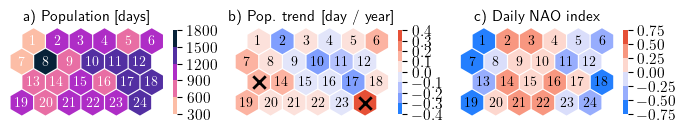

In [66]:
fig, axes = plt.subplots(1, 3, figsize=(TEXTWIDTH_IN, 1.46), tight_layout=True, subplot_kw=dict(aspect="equal"))
axes = axes.ravel()
cmap = colormaps.bubblegum_r
fig, axes[0] = net.plot_on_map(
    populations,
    smooth_sigma=0,
    show=False,
    cmap=cmap,
    fig=fig,
    ax=axes[0],
    discretify=True,
)
axes[0].set_title("a) Population [days]", pad=2)
cmap = colormaps.cet_d_bwr
fig, axes[1] = net.plot_on_map(
    trends,
    smooth_sigma=0,
    show=False,
    cmap=cmap,
    discretify=True,
    fig=fig,
    ax=axes[1],
)
where_signif = np.where(pvalues < 0.05)[0]
signif = net.neighborhoods.coordinates[where_signif]
# axes[1].scatter(*coords.T, s=260, edgecolors="black", marker="h", linewidths=1., facecolors="none")
axes[1].scatter(*signif.T, s=80, c="black", marker="x", linewidths=2.)
axes[1].set_title("b) Pop. trend [day / year]", pad=2)
fig, axes[2] = net.plot_on_map(
    nao_on_map,
    smooth_sigma=0,
    show=False,
    fig=fig,
    ax=axes[2],
    cmap=cmap,
    # discretify=True,
    norm=BoundaryNorm(np.linspace(-0.75, 0.75, 7), cmap.N)
)
axes[2].set_title("c) Daily NAO index", pad=2)
for i, c in enumerate(coords):
    x, y = c
    for j, ax in enumerate(axes):
        color = "white" if j == 0 else "black"
        if j == 1 and i in where_signif:
            continue
        ax.text(x, y, f'${to_prettier_order(i)}$', va='center', ha='center', color=color, fontsize=10)
fig.savefig(f'{FIGURES}/som_props/pop_trend_nao.png')

## PVs

In [67]:
da_pvs = Experiment("ERA5", "surf", "pvs", "6H", "all", "JJA", *exp_s.region, 250, "hourofyear", {"hourofyear": ("win", 60)}).da

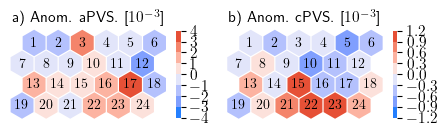

In [68]:
time_mask = np.isin(labels.time.values, da_pvs.time.values)
to_plot_anti = np.asarray([da_pvs.loc[:, 'anti'][mask_[time_mask]].mean().item() for mask_ in mask.T])
to_plot_cycl = np.asarray([da_pvs.loc[:, 'cycl'][mask_[time_mask]].mean().item() for mask_ in mask.T])

fig, axes = plt.subplots(1, 2, figsize=(0.66 * TEXTWIDTH_IN, 1.5), tight_layout=True, subplot_kw=dict(aspect="equal"))
fig, axes[0] = net.plot_on_map(
    to_plot_anti * 1000,
    smooth_sigma=0,
    show=False,
    cmap=colormaps.cet_d_bwr,
    fig=fig,
    ax=axes[0],
    discretify=True,
)
axes[0].set_title(r"a) Anom. aPVS. [$10^{-3}$]", pad=2)
fig, axes[1] = net.plot_on_map(
    to_plot_cycl * 1000,
    smooth_sigma=0,
    fig=fig,
    cmap=colormaps.cet_d_bwr,
    ax=axes[1],
    discretify=True,
)
axes[1].set_title(r"b) Anom. cPVS. [$10^{-3}$]", pad=2)
for i, c in enumerate(coords):
    x, y = c
    for j, ax in enumerate(axes):
        ax.text(x, y, f'${to_prettier_order(i)}$', va='center', ha='center', color="black", fontsize=10)
fig.savefig(f'{FIGURES}/som_props/PVS_activity.png')

## rt, $\sigma=0$

In [69]:
yearbreak = np.sum(labels.time.dt.year.values == 1999)
mean_res, max_res, trend_res, pvalues = net.compute_residence_time(0, yearbreak=yearbreak, q=0.95)

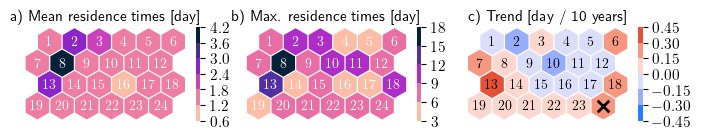

In [70]:
fig, axes = plt.subplots(1, 3, figsize=(TEXTWIDTH_IN, 1.55), tight_layout=True, subplot_kw=dict(aspect="equal"))
axes = axes.ravel()
cmap = colormaps.bubblegum_r
fig, axes[0] = net.plot_on_map(
    mean_res / 4,
    smooth_sigma=0,
    show=False,
    cmap=cmap,
    fig=fig,
    ax=axes[0],
    discretify=True,
)
axes[0].set_title("a) Mean residence times [day]")
fig, axes[1] = net.plot_on_map(
    max_res / 4,
    smooth_sigma=0,
    show=False,
    cmap=cmap,
    fig=fig,
    ax=axes[1],
    discretify=True,
)
axes[1].set_title("b) Max. residence times [day]")
fig, axes[2] = net.plot_on_map(
    trend_res / 4 * 10,
    smooth_sigma=0,
    show=False,
    fig=fig,
    ax=axes[2],
    cmap=colormaps.cet_d_bwr,
    discretify=True,
)
axes[2].set_title("c) Trend [day / 10 years]")
where_signif = np.where(pvalues < 0.05)[0]
signif = net.neighborhoods.coordinates[where_signif]
axes[2].scatter(*signif.T, s=70, c="black", marker="x", linewidths=2)
for i, c in enumerate(coords):
    x, y = c
    for j, ax in enumerate(axes):
        color = "white" if j < 2 else "black"
        if j == 2 and i in where_signif:
            continue
        ax.text(x, y, f'${to_prettier_order(i)}$', va='center', ha='center', color=color, fontsize=10)
fig.savefig(f'{FIGURES}/som_props/residence.png')

## rt, $\sigma=1$

In [71]:
yearbreak = np.sum(labels.time.dt.year.values == 1999)
mean_res, max_res, trend_res, pvalues = net.compute_residence_time(1, yearbreak=yearbreak)

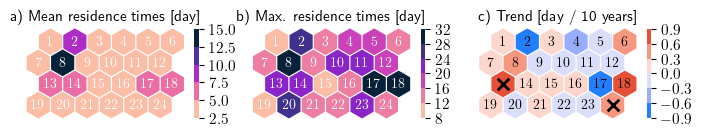

In [72]:
fig, axes = plt.subplots(1, 3, figsize=(TEXTWIDTH_IN, 1.55), tight_layout=True, subplot_kw=dict(aspect="equal"))
axes = axes.ravel()
fig, axes[0] = net.plot_on_map(
    mean_res / 4,
    smooth_sigma=0,
    show=False,
    cmap=cmap,
    fig=fig,
    ax=axes[0],
    discretify=True,
    cbar_kwargs=dict(shrink=0.75)
)
axes[0].set_title("a) Mean residence times [day]")
fig, axes[1] = net.plot_on_map(
    max_res / 4,
    smooth_sigma=0,
    show=False,
    cmap=cmap,
    fig=fig,
    ax=axes[1],
    discretify=True,
    cbar_kwargs=dict(shrink=0.75)
)
axes[1].set_title("b) Max. residence times [day]")
fig, axes[2] = net.plot_on_map(
    trend_res / 4 * 10,
    smooth_sigma=0,
    show=False,
    fig=fig,
    ax=axes[2],
    cmap=colormaps.cet_d_bwr,
    discretify=True,
    cbar_kwargs=dict(shrink=0.75)
)
axes[2].set_title("c) Trend [day / 10 years]")
where_signif = np.where(pvalues < 0.05)[0]
signif = net.neighborhoods.coordinates[where_signif]
axes[2].scatter(*signif.T, s=70, c="black", marker="x", linewidths=2)
for i, c in enumerate(coords):
    x, y = c
    for j, ax in enumerate(axes):
        color = "white" if j < 2 else "black"
        if j == 2 and i in where_signif:
            continue
        ax.text(x, y, f'${to_prettier_order(i)}$', va='center', ha='center', color=color, fontsize=10)
fig.savefig(f'{FIGURES}/som_props/residence_sigma1.png')

## lagged backwards diffusion

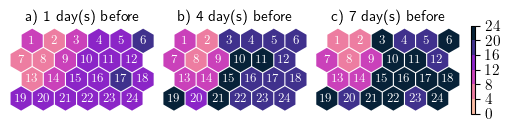

In [73]:
fig, axes = plt.subplots(1, 3, figsize=(TEXTWIDTH_IN, 1.), gridspec_kw=dict(wspace=0.06, hspace=0.02, bottom=0.00, top=0.98), tight_layout=False, subplot_kw=dict(aspect="equal"))
axes = axes.ravel()
norm = BoundaryNorm(np.arange(0, net.n_nodes + 4, 4), cmap.N)
im = ScalarMappable(norm, cmap)
fig.colorbar(im, ax=axes, pad=0.02, shrink=0.9)
steps = [4, 16, 28]
for step, ax, letter in zip(steps, axes, ["a", "b", "c"]):
    transmat = net.compute_transmat(step=step, yearbreaks=yearbreak)
    dilution = np.sum(transmat > 0.01, axis=0)
    fig, ax = net.plot_on_map(
        dilution,
        smooth_sigma=0,
        show=False,
        cmap=cmap,
        norm=norm,
        fig=fig,
        ax=ax,
        draw_cbar=False,
    ) 
    ax.set_title(f"{letter}) {step // 4} day(s) before", pad=2)
fig.set_tight_layout(False)
for i, c in enumerate(coords):
    x, y = c
    for j, ax in enumerate(axes):
        ax.text(x, y, f'${to_prettier_order(i)}$', va='center', ha='center', color="white", fontsize=9)
fig.savefig(f'{FIGURES}/som_props/dilution_before.png')

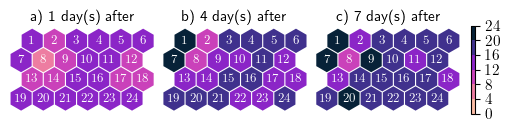

In [74]:
fig, axes = plt.subplots(1, 3, figsize=(TEXTWIDTH_IN, 1.), gridspec_kw=dict(wspace=0.06, hspace=0.02, bottom=0.00, top=0.98), tight_layout=False, subplot_kw=dict(aspect="equal"))
axes = axes.ravel()
norm = BoundaryNorm(np.arange(0, net.n_nodes + 4, 4), cmap.N)
im = ScalarMappable(norm, cmap)
fig.colorbar(im, ax=axes, pad=0.02, shrink=0.9)
steps = [4, 16, 28]
for step, ax, letter in zip(steps, axes, ["a", "b", "c"]):
    transmat = net.compute_transmat(step=step, yearbreaks=yearbreak)
    dilution = np.sum(transmat > 0.01, axis=1)
    fig, ax = net.plot_on_map(
        dilution,
        smooth_sigma=0,
        show=False,
        cmap=cmap,
        norm=norm,
        fig=fig,
        ax=ax,
        draw_cbar=False,
    ) 
    ax.set_title(f"{letter}) {step // 4} day(s) after", pad=2)
fig.set_tight_layout(False)
for i, c in enumerate(coords):
    x, y = c
    for j, ax in enumerate(axes):
        ax.text(x, y, f'${to_prettier_order(i)}$', va='center', ha='center', color="white", fontsize=9)
fig.savefig(f'{FIGURES}/som_props/dilution_after.png')

## lagged backwards transitions

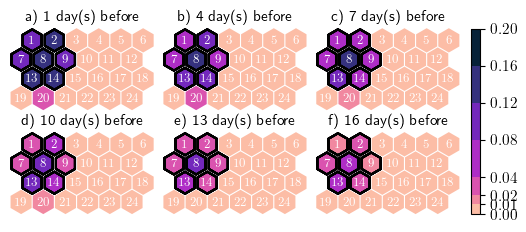

In [79]:
fig, axes = plt.subplots(2, 3, figsize=(TEXTWIDTH_IN, 2.1), gridspec_kw=dict(wspace=0.06, hspace=0.02, bottom=0.00, top=0.98), tight_layout=False, subplot_kw=dict(aspect="equal"))
norm = BoundaryNorm([0, 0.01, 0.02, 0.04, 0.08, 0.12, 0.16, 0.2], cmap.N)
im = ScalarMappable(norm, cmap)
fig.colorbar(im, ax=axes, spacing="proportional", shrink=0.9, pad=0.02)
to_ = [1, 2, 3, 5, 6, 7, 10]
coords = net.neighborhoods.coordinates
coords_subset = net.neighborhoods.coordinates[to_]
for i, (ax, letter) in enumerate(zip(axes.ravel(), list("abcdef"))):
    step = 4 + 12 * i
    transmat = np.mean(net.compute_transmat(step=step, yearbreaks=yearbreak)[:, to_], axis=1)
    fig, ax = net.plot_on_map(
        transmat,
        smooth_sigma=0,
        show=False,
        cmap=cmap,
        norm=norm,
        fig=fig,
        ax=ax,
        draw_cbar=False,
    )
    for j in to_:
        ax.scatter(*coords_subset.T, s=250, edgecolors="black", marker="h", linewidths=1.5, facecolors="none")
    ax.set_title(f"{letter}) {step // 4} day(s) before", pad=2)
fig.set_tight_layout(False)
for i, c in enumerate(coords):
    x, y = c
    for j, ax in enumerate(axes.ravel()):
        ax.text(x, y, f'${to_prettier_order(i)}$', va='center', ha='center', color="white", fontsize=9)
plt.savefig(f'{FIGURES}/som_props/lagged_transition_subspace.png')

## Back and forward mean distance

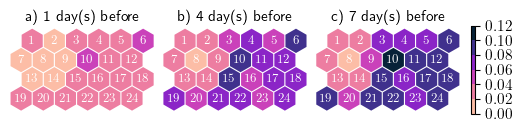

In [80]:
fig, axes = plt.subplots(1, 3, figsize=(TEXTWIDTH_IN, 1.), gridspec_kw=dict(wspace=0.06, hspace=0.02, bottom=0.00, top=0.98), tight_layout=False, subplot_kw=dict(aspect="equal"))
axes = axes.ravel()
norm = BoundaryNorm(np.arange(0, 0.13, 0.02), cmap.N)
im = ScalarMappable(norm, cmap)
fig.colorbar(im, ax=axes, pad=0.02, shrink=0.9)
steps = [4, 16, 28]
dists = net.neighborhoods.distances
for step, ax, letter in zip(steps, axes, list("abc")):
    transmat = net.compute_transmat(step=step, yearbreaks=yearbreak)
    mean_dists = np.zeros(net.n_nodes)
    for node, col in enumerate(transmat.T):
        mean_dists[node] = np.mean(col * dists[node])
    
    fig, ax = net.plot_on_map(
        mean_dists,
        smooth_sigma=0,
        show=False,
        cmap=cmap,
        norm=norm,
        fig=fig,
        ax=ax,
        draw_cbar=False,
    ) 
    ax.set_title(f"{letter}) {step // 4} day(s) before", pad=2)
fig.set_tight_layout(False)
for i, c in enumerate(coords):
    x, y = c
    for j, ax in enumerate(axes.ravel()):
        ax.text(x, y, f'${to_prettier_order(i)}$', va='center', ha='center', color="white", fontsize=9)
fig.savefig(f'{FIGURES}/som_props/distance_dilution_before.png')

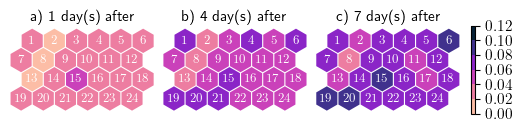

In [81]:
fig, axes = plt.subplots(1, 3, figsize=(TEXTWIDTH_IN, 1.), gridspec_kw=dict(wspace=0.06, hspace=0.02, bottom=0.00, top=0.98), tight_layout=False, subplot_kw=dict(aspect="equal"))
axes = axes.ravel()
norm = BoundaryNorm(np.arange(0, 0.13, 0.02), cmap.N)
im = ScalarMappable(norm, cmap)
fig.colorbar(im, ax=axes, pad=0.02, shrink=0.9)
steps = [4, 16, 28]
dists = net.neighborhoods.distances
for step, ax, letter in zip(steps, axes, list("abc")):
    transmat = net.compute_transmat(step=step, yearbreaks=yearbreak)
    mean_dists = np.zeros(net.n_nodes)
    for node, line in enumerate(transmat):
        mean_dists[node] = np.mean(line * dists[node])
    
    fig, ax = net.plot_on_map(
        mean_dists,
        smooth_sigma=0,
        show=False,
        cmap=cmap,
        norm=norm,
        fig=fig,
        ax=ax,
        draw_cbar=False,
    ) 
    ax.set_title(f"{letter}) {step // 4} day(s) after", pad=2)
fig.set_tight_layout(False)
for i, c in enumerate(coords):
    x, y = c
    for j, ax in enumerate(axes.ravel()):
        ax.text(x, y, f'${to_prettier_order(i)}$', va='center', ha='center', color="white", fontsize=9)
fig.savefig(f'{FIGURES}/som_props/distance_dilution_after.png')

## jet indices

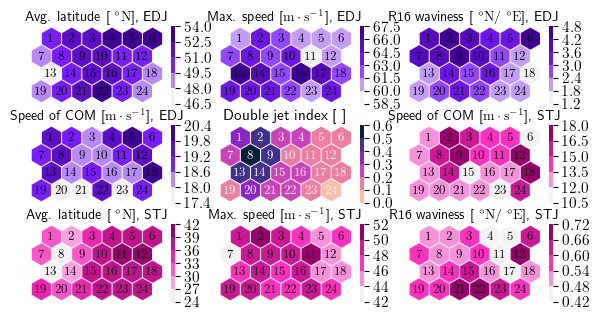

In [84]:
data_vars_and_jets = [
    ("mean_lat", "polar"),
    ("spe_star", "polar"),
    ("wavinessR16", "polar"),
    ("com_speed", "polar"),
    ("double_jet_index", "_"),
    ("com_speed", "subtropical"),
    ("mean_lat", "subtropical"),
    ("spe_star", "subtropical"),
    ("wavinessR16", "subtropical"),
]
fig, axes = plt.subplots(3, 3, figsize=(TEXTWIDTH_IN, 2.9), gridspec_kw=dict(wspace=0.15, hspace=0.15, bottom=0.00, top=0.98), sharex="all", subplot_kw=dict(aspect="equal"))
axes = axes.flatten()
for (varname, jet), ax in zip(data_vars_and_jets, axes):
    try:
        to_plot = props_as_ds_summer[varname].sel(jet=jet)
        cmap = MYPURPLES if jet == "polar" else MYPINKS
        ax.set_title(f"{PRETTIER_VARNAME[varname]} [{UNITS.get(varname, '')}], {SHORTHAND[jet]}", pad=2, fontsize=10)
    except KeyError:
        to_plot = props_as_ds_summer[varname]
        cmap = colormaps.bubblegum_r
        ax.set_title(f"{PRETTIER_VARNAME[varname]} [{UNITS.get(varname, '')}]", pad=2)
    to_plot = timeseries_on_map(to_plot, net.bmus)[0]
    fig, ax = net.plot_on_map(
        to_plot,
        smooth_sigma=0,
        show=False,
        fig=fig,
        ax=ax,
        draw_cbar=True,
        cmap=cmap,
        discretify=True,
        cbar_kwargs=dict(shrink=0.9)
    )
for i, c in enumerate(coords):
    x, y = c
    for j, ax in enumerate(axes.ravel()):
        color = "white" if j == 4 else "black" 
        ax.text(x, y, f'${to_prettier_order(i)}$', va='center', ha='center', color=color, fontsize=9)
fig.savefig(f'{FIGURES}/som_props/combined_indices.png')

In [ ]:
def std_on_map(timeseries, labels):
    timeseries = np.atleast_2d(timeseries)
    mask = labels_to_mask(labels)
    return np.asarray(
        [[np.nanmean(timeseries_[mas]) for mas in mask.T] for timeseries_ in timeseries]
    )
data_vars_and_jets = [
    ("mean_lat", "polar"),
    ("spe_star", "polar"),
    ("wavinessR16", "polar"),
    ("com_speed", "polar"),
    ("double_jet_index", "_"),
    ("com_speed", "subtropical"),
    ("mean_lat", "subtropical"),
    ("spe_star", "subtropical"),
    ("wavinessR16", "subtropical"),
]
fig, axes = plt.subplots(3, 3, figsize=(TEXTWIDTH_IN, 2.9), gridspec_kw=dict(wspace=0.15, hspace=0.15, bottom=0.00, top=0.98), sharex="all", subplot_kw=dict(aspect="equal"))
axes = axes.flatten()
for (varname, jet), ax in zip(data_vars_and_jets, axes):
    try:
        to_plot = props_as_ds_summer[varname].sel(jet=jet)
        cmap = MYPURPLES if jet == "polar" else MYPINKS
        ax.set_title(f"{PRETTIER_VARNAME[varname]} [{UNITS.get(varname, '')}], {SHORTHAND[jet]}", pad=2, fontsize=10)
    except KeyError:
        to_plot = props_as_ds_summer[varname]
        cmap = colormaps.bubblegum_r
        ax.set_title(f"{PRETTIER_VARNAME[varname]} [{UNITS.get(varname, '')}]", pad=2)
    to_plot = std_on_map(to_plot, net.bmus)[0]
    fig, ax = net.plot_on_map(
        to_plot,
        smooth_sigma=0,
        show=False,
        fig=fig,
        ax=ax,
        draw_cbar=True,
        cmap=cmap,
        discretify=True,
        cbar_kwargs=dict(shrink=0.9)
    )
for i, c in enumerate(coords):
    x, y = c
    for j, ax in enumerate(axes.ravel()):
        color = "white" if j == 4 else "black" 
        ax.text(x, y, f'${to_prettier_order(i)}$', va='center', ha='center', color=color, fontsize=9)
fig.savefig(f'{FIGURES}/som_props/combined_indices_stds.png')

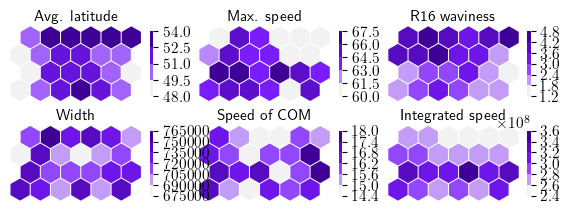

In [27]:
data_vars = ["mean_lat", "Spe", "sinuosity3", "width", "com_speed", "int"]
jet = "polar"

fig, axes = plt.subplots(2, 3, figsize=(TEXTWIDTH_IN, 1.9), gridspec_kw=dict(wspace=0.15, hspace=0.15, bottom=0.00, top=0.98), sharex="all", subplot_kw=dict(aspect="equal"))
axes = axes.flatten()
for varname, ax in zip(data_vars, axes):
    try:
        to_plot = props_as_ds_summer[varname].sel(jet=jet)
    except KeyError:
        to_plot = props_as_ds_summer[varname]
    to_plot = timeseries_on_map(to_plot, net.bmus)[0]
    fig, ax = net.plot_on_map(
        to_plot,
        smooth_sigma=0,
        show=False,
        fig=fig,
        ax=ax,
        draw_cbar=True,
        cmap=MYPURPLES,
        discretify=True,
        cbar_kwargs=dict(shrink=0.75)
    )
    ax.set_title(f"{PRETTIER_VARNAME[varname]}", pad=2)
    # ax.set_title(f"{PRETTIER_VARNAME[varname]}, [{UNITS[varname]}]")
fig.savefig(f'{FIGURES}/som_props/polar_indices.png')

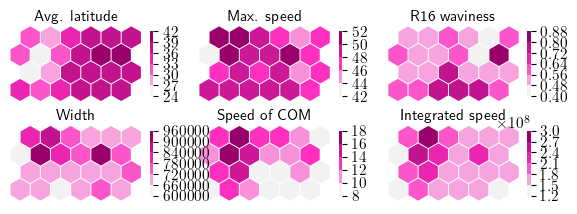

In [28]:
data_vars = ["mean_lat", "Spe", "sinuosity3", "width", "com_speed", "int"]
jet = "subtropical"

fig, axes = plt.subplots(2, 3, figsize=(TEXTWIDTH_IN, 1.9), gridspec_kw=dict(wspace=0.15, hspace=0.15, bottom=0.00, top=0.98), sharex="all", subplot_kw=dict(aspect="equal"))
axes = axes.flatten()
for varname, ax in zip(data_vars, axes):
    try:
        to_plot = props_as_ds_summer[varname].sel(jet=jet)
    except KeyError:
        to_plot = props_as_ds_summer[varname]
    to_plot = timeseries_on_map(to_plot, net.bmus)[0]
    fig, ax = net.plot_on_map(
        to_plot,
        smooth_sigma=0,
        show=False,
        fig=fig,
        ax=ax,
        draw_cbar=True,
        cmap=MYPINKS,
        discretify=True,
        cbar_kwargs=dict(shrink=0.75)
    )
    ax.set_title(f"{PRETTIER_VARNAME[varname]}", pad=2)
    # ax.set_title(f"{PRETTIER_VARNAME[varname]}, [{UNITS[varname]}]")
fig.savefig(f'{FIGURES}/som_props/subtropical_indices.png')

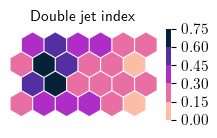

In [29]:
varname = "double_jet_index"
cmap = colormaps.bubblegum_r

fig, ax = plt.subplots(1, 1, figsize=(0.33 * TEXTWIDTH_IN, 1.5), tight_layout=True, sharex="all", subplot_kw=dict(aspect="equal"))
to_plot = props_as_ds_summer[varname]
to_plot = timeseries_on_map(to_plot, net.bmus)[0]
fig, ax = net.plot_on_map(
    to_plot,
    smooth_sigma=0,
    show=False,
    fig=fig,
    ax=ax,
    draw_cbar=True,
    cmap=cmap,
    discretify=True,
    cbar_kwargs=dict(shrink=0.85)
)
ax.set_title(f"{PRETTIER_VARNAME[varname]}")
fig.savefig(f'{FIGURES}/som_props/double_jet_index.png')